In [67]:
%load_ext autoreload
%autoreload 2

import torch
from model import PointNet
from dataset import lm2flat_index
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from typing import List, Tuple
from dataset import OctantDataset
from torch.utils.data import DataLoader
from pytorch3d.structures import Pointclouds
import torch.utils.data as data

ds = OctantDataset("../datasets/neuschwanstein_16_sh")

def collate_batched_point_clouds(batch: List[Tuple[Pointclouds, torch.Tensor]]):
    coefs = torch.stack([x[1] for x in batch])
    pcs = Pointclouds(
        points=[x[0].points_packed() for x in batch],
        features=[x[0].features_packed() for x in batch],
    )
    return (pcs, coefs)

num_train = int(0.8*len(ds))

ds_train, ds_val = data.random_split(ds,[num_train,len(ds)-num_train])

batch_size = 256

train_dataloader = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=True,num_workers=12,pin_memory=True
)
val_dataloader = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, collate_fn=collate_batched_point_clouds, drop_last=True,num_workers=3,pin_memory=True
)
len(ds_train),len(ds_val)

(30476, 7620)

In [84]:
l = 5
model = PointNet((l + 1) ** 2,batch_norm=False).cuda()

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

0it [00:00, ?it/s]

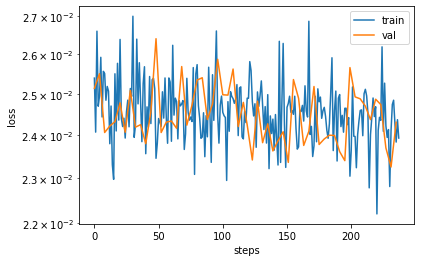

In [85]:
from torch.optim.lr_scheduler import OneCycleLR 

epochs = 2

scheduler = OneCycleLR(optimizer,max_lr=1e-3,steps_per_epoch=len(train_dataloader),epochs=epochs)

mse_loss = torch.nn.MSELoss()

def unpack_data(pcs:Pointclouds):
    vertices = pcs.points_packed().cuda()
    color = (pcs.features_packed()[:, :3]).cuda().float() / 255.0
    batch = pcs.packed_to_cloud_idx().cuda()
    return vertices,color,batch


loss_hist_train = {}
loss_hist_val = {}
step=0

with tqdm(len(train_dataloader)) as pbar:
    for epoch in range(epochs):

        pbar.reset(len(train_dataloader))
        pbar.set_description(f"epoch {epoch+1}/{epochs}")

        val_sampler = iter(val_dataloader)

        for i,(pcs, coefs) in enumerate(iter(train_dataloader)):
            model.train()
            vertices,color,batch = unpack_data(pcs)
            target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()
            optimizer.zero_grad()

            pred_coefs = model(vertices, color, batch)
            train_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
            train_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.)
            optimizer.step()
            loss_hist_train[step] = train_loss.item()
            scheduler.step()

            # do validation batch every 4th train batch
            if i%4 == 0:
                model.eval()
                pcs,coefs = next(val_sampler)
                vertices,color,batch = unpack_data(pcs)
                target_coefs = coefs[:, : lm2flat_index(l, -l) + 1].cuda()
                pred_coefs = model(vertices, color, batch)
                val_loss:torch.Tensor = mse_loss(pred_coefs, target_coefs)
                loss_hist_val[step] = val_loss.item()

            pbar.update()
            step+=1

plt.plot(loss_hist_train.keys(),loss_hist_train.values(), label="train")
plt.plot(loss_hist_val.keys(),loss_hist_val.values(), label="val")
plt.legend()
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale("log")


In [76]:
from sh import calc_sh

res = 100


x = torch.arange(0,1,1/res)
grid_x,grid_y = torch.meshgrid(x*torch.pi,x*2*torch.pi,indexing="ij")
coords = torch.stack((grid_x.flatten(),grid_y.flatten())).T

y = calc_sh(l,coords)

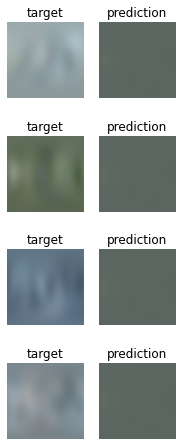

In [77]:
model.eval()
model.requires_grad_(False)

pc,a_lm = next(iter(train_dataloader))

pred_a = model(*unpack_data(pc)).squeeze(0)
a_lm = a_lm[:,:lm2flat_index(l, -l) + 1]

fig,axes = plt.subplots(4,2,figsize=(3,8))

for i in range(4):
    ax1,ax2 = axes[i]
    ax1.set_title("target")
    ax1.set_axis_off()
    ax1.imshow((y@a_lm[i].cpu()).reshape(res,res,-1))
    ax2.set_title("prediction")
    ax2.set_axis_off()
    ax2.imshow((y@pred_a[i].cpu()).reshape(res,res,-1))

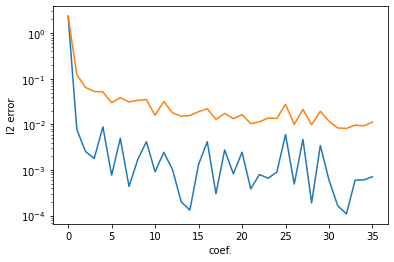

In [81]:
plt.ylabel("l2 error")
plt.xlabel("coef.")
# plt.plot((a_lm-pred_a.cpu()).norm(2,-1).mean(0),label="error")
plt.plot((pred_a.cpu()).norm(2,-1).mean(0))
plt.plot((a_lm.cpu()).norm(2,-1).mean(0))
plt.yscale("log")